# Feature engineering. CASE: Loans Accepted vs. Rejected

`Loan accepted`: If the company approves the loan, we will assume that loan can have such statuses:
- Fully paid: Applicant has fully paid the loan.
- Current: Applicant is in the process of paying the instalments, i.e. the tenure of the loan is not yet completed. These candidates are not labelled as 'defaulted'.

`Loan rejected`: We will assume such loans with the status:
- Charged-off: Applicant has not paid the instalments in due time for a long period of time, i.e. he/she has defaulted on the loan.
- Default

In [3]:
#pip install imbalanced-learn

In [3]:
#pip install imblearn

In [1]:
import numpy as np
import pandas as pd
from pandasql import sqldf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import plotly.offline as pyo
import plotly.express as px
import plotly.graph_objects as go
import math

from matplotlib.ticker import MaxNLocator, MultipleLocator
from matplotlib.dates import YearLocator, DateFormatter

import scipy.stats.distributions as dist
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats

from dask import dataframe as dd
import time

from generic_functions import check_duplicates, check_missing_values, value_counts_to_dataframe, pivot_dim2

pd.set_option('display.max_columns', None)

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from generic_functions import value_counts_to_dataframe, pivot_dim2
# from modelling_functions import fit_model, kfold_cross_validation
from pca_functions import plot_variance, make_mi_scores

# balancing dataset
from imblearn.over_sampling import SMOTE

from sklearn import model_selection
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold

from sklearn import metrics
# from sklearn.metrics import roc_curve, auc
from sklearn.metrics import auc
# from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc_curve
# from sklearn.metrics import plot_roc_curve
from sklearn.metrics import RocCurveDisplay
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import precision_recall_curve


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
#from xgboost import XGBRegressor
import xgboost as xgb

from sklearn.pipeline import Pipeline

from scipy.stats import reciprocal, uniform

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

os.getcwd()

'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3'

In [2]:
import glob
os.chdir('/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/input')

In [3]:
files_ = [f for f in glob.glob("*.csv")]
files_

['lending_data_2018.csv',
 'lending_data_2009.csv',
 'lending_data_2008.csv',
 'lending_data_2011.csv',
 'lending_data_2010.csv',
 'lending_data_2012.csv',
 'lending_data_2007.csv',
 'lending_data_2013.csv',
 'lending_data_2017.csv',
 'lending_data_2016.csv',
 'lending_data_2014.csv',
 'lending_data_2015.csv']

In [47]:
years_ = ['2015', '2016','2017']

In [59]:
matching = []
lst = []
j = 1
for i in years_:
    matching_stg = [s for s in files_ if i in s][0]
    matching.append(matching_stg)
    
for url in matching:  
    path_ = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/input/{url}'
    data = pd.read_csv(path_)
    lst.append(data)                        
df_ = pd.concat(lst)

df_.info()
print(df_.year.unique())
df_ = df_.drop(columns = ['index','level_0','id'])
df_.head(3)


<class 'pandas.core.frame.DataFrame'>
Index: 1299081 entries, 0 to 443578
Columns: 154 entries, level_0 to year
dtypes: float64(113), int64(4), object(37)
memory usage: 1.5+ GB
[2015 2016 2017]


,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,year
0,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.0,0.0,4421.723917,4421.72,3600.0,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,2015
1,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.0,0.0,25679.660000,25679.66,24700.0,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [60]:
df_.shape

(1299081, 151)

# Selecting attributes

In [61]:
columns = ['loan_amnt','funded_amnt','int_rate',
           'installment','annual_inc','dti','fico_range_low',
           'fico_range_high','inq_last_6mths',
           'open_acc','pub_rec','revol_bal','revol_util',
           ## categorical variables
           'term','grade','sub_grade','emp_title','emp_length',
           'home_ownership','verification_status','loan_status',
           'purpose','addr_state','application_type']

In [62]:
df_ = df_[columns]
df_.head(5)

,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,loan_status,purpose,addr_state,application_type
0,3600.0,3600.0,13.99,123.03,55000.0,5.91,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,36 months,C,C4,leadman,10+ years,MORTGAGE,Not Verified,Fully Paid,debt_consolidation,PA,Individual
1,24700.0,24700.0,11.99,820.28,65000.0,16.06,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,36 months,C,C1,Engineer,10+ years,MORTGAGE,Not Verified,Fully Paid,small_business,SD,Individual
2,20000.0,20000.0,10.78,432.66,63000.0,10.78,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,60 months,B,B4,truck driver,10+ years,MORTGAGE,Not Verified,Fully Paid,home_improvement,IL,Joint App
3,35000.0,35000.0,14.85,829.90,110000.0,17.06,785.0,789.0,0.0,13.0,0.0,7802.0,11.6,60 months,C,C5,Information Systems Officer,10+ years,MORTGAGE,Source Verified,Current,debt_consolidation,NJ,Individual
4,10400.0,10400.0,22.45,289.91,104433.0,25.37,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,60 months,F,F1,Contract Specialist,3 years,MORTGAGE,Source Verified,Fully Paid,major_purchase,PA,Individual


Let's check if there are any missing values for categorical attributes

In [63]:
check_missing_values(df_)
print(df_.isna().sum())

Table has missing values
loan_amnt                  0
funded_amnt                0
int_rate                   0
installment                0
annual_inc                 0
dti                      579
fico_range_low             0
fico_range_high            0
inq_last_6mths             1
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util               870
term                       0
grade                      0
sub_grade                  0
emp_title              84711
emp_length             83902
home_ownership             0
verification_status        0
loan_status                0
purpose                    0
addr_state                 0
application_type           0
dtype: int64


We will drop `emp_title` and `emp_length` missing recors.

In [64]:
df_ = df_[df_.emp_length.isna() == False].reset_index()
df_ = df_[df_.emp_title.isna() == False].reset_index()
df_ = df_.drop(columns=['level_0','index'])
print(df_.shape)
df_.head(3)

(1213786, 24)


,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,loan_status,purpose,addr_state,application_type
0,3600.0,3600.0,13.99,123.03,55000.0,5.91,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,36 months,C,C4,leadman,10+ years,MORTGAGE,Not Verified,Fully Paid,debt_consolidation,PA,Individual
1,24700.0,24700.0,11.99,820.28,65000.0,16.06,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,36 months,C,C1,Engineer,10+ years,MORTGAGE,Not Verified,Fully Paid,small_business,SD,Individual
2,20000.0,20000.0,10.78,432.66,63000.0,10.78,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,60 months,B,B4,truck driver,10+ years,MORTGAGE,Not Verified,Fully Paid,home_improvement,IL,Joint App


In [65]:
cols = ['term','grade','sub_grade','emp_title','emp_length',
           'home_ownership','verification_status','loan_status',
           'purpose','addr_state','application_type']

df_test = df_[cols]

print("Columns unique values:")

for i in df_test[cols]:
    print(i,": ",df_test[i].unique())

Columns unique values:
term :  [' 36 months' ' 60 months']
grade :  ['C' 'B' 'F' 'A' 'E' 'D' 'G']
sub_grade :  ['C4' 'C1' 'B4' 'C5' 'F1' 'C3' 'B2' 'B1' 'A2' 'B5' 'C2' 'E2' 'A4' 'E3'
 'A1' 'D4' 'F3' 'D1' 'B3' 'E4' 'D3' 'D2' 'D5' 'A5' 'F2' 'E1' 'F5' 'E5'
 'A3' 'G2' 'G1' 'G3' 'G4' 'F4' 'G5']
emp_title :  ['leadman' 'Engineer' 'truck driver' ... 'Acft mechanic' 'Content Review '
 'BABYSITTER']
emp_length :  ['10+ years' '3 years' '4 years' '6 years' '1 year' '7 years' '8 years'
 '5 years' '2 years' '9 years' '< 1 year']
home_ownership :  ['MORTGAGE' 'RENT' 'OWN' 'ANY' 'NONE']
verification_status :  ['Not Verified' 'Source Verified' 'Verified']
loan_status :  ['Fully Paid' 'Current' 'Charged Off' 'In Grace Period'
 'Late (31-120 days)' 'Late (16-30 days)' 'Default']
purpose :  ['debt_consolidation' 'small_business' 'home_improvement' 'major_purchase'
 'credit_card' 'other' 'house' 'car' 'medical' 'vacation' 'moving'
 'renewable_energy' 'wedding' 'educational']
addr_state :  ['PA' 'SD' 'IL' 

# Loans distribution to accepted vs. rejected

In [66]:
df_.loan_status.unique()

array(['Fully Paid', 'Current', 'Charged Off', 'In Grace Period',
       'Late (31-120 days)', 'Late (16-30 days)', 'Default'], dtype=object)

In [67]:
loan_status_mapping = {
    'Fully Paid': 'Accepted',
    'Current': 'Accepted',
    'Charged Off': 'Rejected',
    'Default': 'Rejected',
    'In Grace Period': 'Other',
    'Late (31-120 days)': 'Other',
    'Late (16-30 days)': 'Other' 
    }
df_['LoanAcceptReject'] = df_.loan_status.apply(lambda x: loan_status_mapping[x])
df = df_[df_.LoanAcceptReject != 'Other'].reset_index()
df = df.rename(columns={'index':'id'})
df.shape
df.head(3)

,id,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,loan_status,purpose,addr_state,application_type,LoanAcceptReject
0,0,3600.0,3600.0,13.99,123.03,55000.0,5.91,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,36 months,C,C4,leadman,10+ years,MORTGAGE,Not Verified,Fully Paid,debt_consolidation,PA,Individual,Accepted
1,1,24700.0,24700.0,11.99,820.28,65000.0,16.06,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,36 months,C,C1,Engineer,10+ years,MORTGAGE,Not Verified,Fully Paid,small_business,SD,Individual,Accepted
2,2,20000.0,20000.0,10.78,432.66,63000.0,10.78,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,60 months,B,B4,truck driver,10+ years,MORTGAGE,Not Verified,Fully Paid,home_improvement,IL,Joint App,Accepted


# Baseline

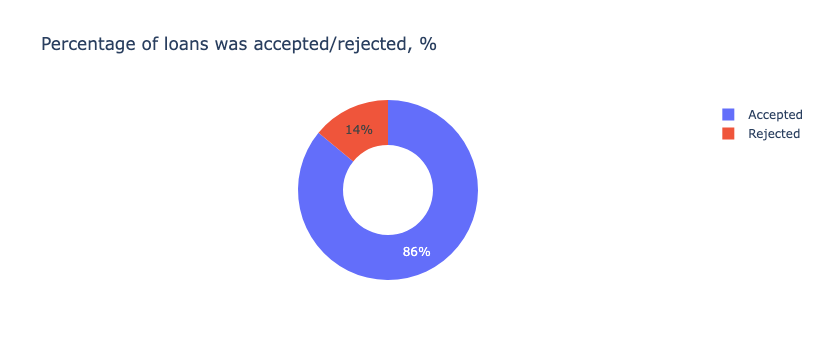

In [68]:
attrib = 'LoanAcceptReject'
temp_df = value_counts_to_dataframe(df,attrib)

fig = px.pie(temp_df, values='counts', 
       names='LoanAcceptReject', 
       hole=.5,
       title=f'Percentage of loans was accepted/rejected, %')
fig.show()

For such an imbalanced dataset, a useful baseline can be to beat the 'Null Accuracy', and in our case, since we're looking for the rejected loans, I will take the inverse of that. In other words, always predicting the most common outcome.

For this case, 167592/(167592+1024870) = 0.14

So a good target to beat would be 14%~ for recall for positive stroke patients.

In [69]:
df.head(3)

,id,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,loan_status,purpose,addr_state,application_type,LoanAcceptReject
0,0,3600.0,3600.0,13.99,123.03,55000.0,5.91,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,36 months,C,C4,leadman,10+ years,MORTGAGE,Not Verified,Fully Paid,debt_consolidation,PA,Individual,Accepted
1,1,24700.0,24700.0,11.99,820.28,65000.0,16.06,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,36 months,C,C1,Engineer,10+ years,MORTGAGE,Not Verified,Fully Paid,small_business,SD,Individual,Accepted
2,2,20000.0,20000.0,10.78,432.66,63000.0,10.78,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,60 months,B,B4,truck driver,10+ years,MORTGAGE,Not Verified,Fully Paid,home_improvement,IL,Joint App,Accepted


In [70]:
# Inverse of Null Accuracy
print('Inverse of Null Accuracy: ',df[df.LoanAcceptReject == 'Rejected'].id.count()/len(df))
print('Null Accuracy: ',df[df.LoanAcceptReject != 'Rejected'].id.count()/len(df))

Inverse of Null Accuracy:  0.14041403763353924
Null Accuracy:  0.8595859623664608


In [71]:
flag_ = {'Rejected': 1,
        'Accepted': 0
        }

df['LoanAcceptRejectFlag'] = df.LoanAcceptReject.apply(lambda x: flag_[x])

# Categorical data standartisation

We have noticed that employment title might be unstructured, case sensitive. Thus we will try to standartise the text values by:
- lowering cases
- grouping some titles

In [72]:
print('Number of unique employment titles:', len(list(df.emp_title.unique())))
df['emp_title_mod'] = df.emp_title.apply(lambda x: str(x).lower())

print('After lower case number of unique employment titles:', len(list(df.emp_title_mod.unique())))

Number of unique employment titles: 278704
After lower case number of unique employment titles: 233571


In [73]:
job_titles = df.groupby('emp_title_mod').agg(Occur=('addr_state','count')).sort_values(by='Occur',ascending = False).reset_index()
job_titles['Share'] = round(job_titles.Occur/job_titles.Occur.sum()*100,1)
job_titles.head(15)

,emp_title_mod,Occur,Share
0,teacher,29038,2.4
1,manager,26772,2.2
2,owner,21289,1.8
3,registered nurse,13166,1.1
4,driver,12771,1.1
5,supervisor,11712,1.0
6,sales,11319,0.9
7,rn,10624,0.9
8,office manager,8135,0.7
9,project manager,8098,0.7


In [74]:
df['emp_title_mod'] = np.where(df['emp_title_mod'].str.contains('nurse') == True, 'nurse', df.emp_title_mod)
df['emp_title_mod'] = np.where(df['emp_title_mod'].str.contains('teacher') == True, 'teacher',df.emp_title_mod)
df['emp_title_mod'] = np.where(df['emp_title_mod'].str.contains('driver') == True, 'driver',df.emp_title_mod)
df['emp_title_mod'] = np.where(df['emp_title_mod'].str.contains('analyst') == True, 'analyst',df.emp_title_mod)
df['emp_title_mod'] = np.where(df['emp_title_mod'].str.contains('engineer') == True, 'engineer',df.emp_title_mod)
df['emp_title_mod'] = np.where(df['emp_title_mod'].str.contains('mechanic') == True, 'mechanic',df.emp_title_mod)
df['emp_title_mod'] = np.where(df['emp_title_mod'].str.contains('accountant') == True, 'accountant',df.emp_title_mod)
df['emp_title_mod'] = np.where(df['emp_title_mod'].str.contains('attorney') == True, 'attorney',df.emp_title_mod)
df['emp_title_mod'] = np.where(df['emp_title_mod'].str.contains('sales') == True, 'sales',df.emp_title_mod)
df['emp_title_mod'] = np.where(df['emp_title_mod'].str.contains('police') == True, 'police',df.emp_title_mod)
df['emp_title_mod'] = np.where(df['emp_title_mod'].str.contains('supervisor') == True, 'supervisor',df.emp_title_mod)
df['emp_title_mod'] = np.where(df['emp_title_mod'].str.contains('owner') == True, 'owner',df.emp_title_mod)
df['emp_title_mod'] = np.where(df['emp_title_mod'].str.contains('manager') == True, 'manager',df.emp_title_mod)
df['emp_title_mod'] = np.where(df['emp_title_mod'].str.contains('director') == True, 'director',df.emp_title_mod)

In [75]:
job_titles = df.groupby('emp_title_mod').agg(Occur=('addr_state','count')).sort_values(by='Occur',ascending = False).reset_index()
job_titles['Share'] = round(job_titles.Occur/job_titles.Occur.sum()*100,1)
job_titles.head(20)

,emp_title_mod,Occur,Share
0,manager,179189,15.0
1,director,48169,4.0
2,sales,46507,3.9
3,engineer,37008,3.1
4,teacher,36917,3.1
5,supervisor,36591,3.1
6,analyst,32509,2.7
7,driver,31976,2.7
8,owner,28885,2.4
9,nurse,28815,2.4


In [76]:
len(list(job_titles.emp_title_mod.unique()))

154423

# Training and Test samples slit

In [318]:
features = ['loan_amnt','funded_amnt','int_rate',
           'installment','annual_inc','dti','fico_range_low',
           'fico_range_high','inq_last_6mths',
           'open_acc','pub_rec','revol_bal','revol_util',
            'term','grade','sub_grade','emp_title_mod','emp_length',
           'home_ownership','verification_status',
           'purpose','addr_state','application_type'
           ]

target = ['LoanAcceptRejectFlag']

In [319]:
X , y = df[features],df[target]

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [320]:
print('Training sample', x_train.shape)
print('Test sample', x_test.shape)

Training sample (954850, 23)
Test sample (238713, 23)


In [321]:
x_train = ((x_train.reset_index()).drop(columns='index')).reset_index()#.rename(columns={'index','id'})
x_train['id'] = x_train[['index']]
x_train.head(2)

x_test = ((x_test.reset_index()).drop(columns='index')).reset_index()#.rename(columns={'index','id'})
x_test['id'] = x_test[['index']]
x_test.head(2)

,index,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,term,grade,sub_grade,emp_title_mod,emp_length,home_ownership,verification_status,purpose,addr_state,application_type,id
0,0,10500.0,10500.0,9.16,334.68,65000.0,14.29,660.0,664.0,1.0,10.0,1.0,12969.0,36.7,36 months,B,B2,mortgage sale associate,2 years,RENT,Source Verified,debt_consolidation,CA,Individual,0
1,1,4200.0,4200.0,14.49,144.55,70000.0,9.51,675.0,679.0,0.0,7.0,0.0,9279.0,40.0,36 months,C,C4,superintendant,10+ years,RENT,Verified,debt_consolidation,WA,Individual,1


# Numerical values preparation

## Check & handling missing values

<b>Training dataset:</b>

In [322]:
check_missing_values(x_train)
print(x_train.isna().sum())

x_train['dti'] = x_train['dti'].fillna(round(x_train['dti'].median(),2))
x_train['revol_util'] = x_train['revol_util'].fillna(round(x_train['revol_util'].median(),2))
x_train['inq_last_6mths'] = x_train['inq_last_6mths'].fillna(round(x_train['inq_last_6mths'].median(),2))

Table has missing values
index                    0
loan_amnt                0
funded_amnt              0
int_rate                 0
installment              0
annual_inc               0
dti                     26
fico_range_low           0
fico_range_high          0
inq_last_6mths           1
open_acc                 0
pub_rec                  0
revol_bal                0
revol_util             611
term                     0
grade                    0
sub_grade                0
emp_title_mod            0
emp_length               0
home_ownership           0
verification_status      0
purpose                  0
addr_state               0
application_type         0
id                       0
dtype: int64


<b>Test dataset:<b>

In [323]:
check_missing_values(x_test)
print(x_test.isna().sum())

x_test['dti'] = x_test['dti'].fillna(round(x_test['dti'].median(),2))
x_test['revol_util'] = x_test['revol_util'].fillna(round(x_test['revol_util'].median(),2))

Table has missing values
index                    0
loan_amnt                0
funded_amnt              0
int_rate                 0
installment              0
annual_inc               0
dti                      7
fico_range_low           0
fico_range_high          0
inq_last_6mths           0
open_acc                 0
pub_rec                  0
revol_bal                0
revol_util             170
term                     0
grade                    0
sub_grade                0
emp_title_mod            0
emp_length               0
home_ownership           0
verification_status      0
purpose                  0
addr_state               0
application_type         0
id                       0
dtype: int64


Export after the adjustment

In [324]:
path_train = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/output_loans/train_test/x_train.csv'
path_test = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/output_loans/train_test/x_test.csv'
x_train_export = x_train.drop(columns=['index','id'])
x_train_export.to_csv(path_train,index=False)
x_test_export = x_test.drop(columns=['index','id'])
x_test_export.to_csv(path_test,index=False)

path_ytrain = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/output_loans/train_test/y_train.csv'
path_ytest = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/output_loans/train_test/y_test.csv'
y_train.to_csv(path_ytrain,index=False)
y_test.to_csv(path_ytest,index=False)

## Normalisation

Data is commonly rescaled to fall between 0 and 1, because machine learning algorithms tend to perform better, or converge faster, when the different features are on a smaller scale. Before training machine learning models on data, it’s common practice to normalize the data first to potentially get better, faster results. Normalization also makes the training process less sensitive to the scale of the features, resulting in better coefficients after training.

In [325]:
num_columns = ['loan_amnt','funded_amnt','int_rate','installment','annual_inc',
'dti','fico_range_low','fico_range_high','inq_last_6mths',
'open_acc','pub_rec','revol_bal','revol_util']

cat_columns = ['id','term', 'grade', 'sub_grade', 'emp_title_mod', 'emp_length', 
               'home_ownership', 'verification_status', 
               'purpose', 'addr_state', 'application_type']

<b>Training dataset:</b>

In [326]:
round(x_train[num_columns].describe(),1).T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,954850.0,15122.7,9113.2,1000.0,8000.0,13000.0,20000.0,40000.0
funded_amnt,954850.0,15122.6,9113.2,1000.0,8000.0,13000.0,20000.0,40000.0
int_rate,954850.0,12.9,4.8,5.3,9.4,12.3,15.6,31.0
installment,954850.0,447.6,267.9,30.1,253.5,380.2,594.8,1719.8
annual_inc,954850.0,80949.0,150775.6,0.0,49000.0,68000.0,96000.0,110000000.0
dti,954850.0,18.9,10.6,-1.0,12.2,18.2,24.8,999.0
fico_range_low,954850.0,696.5,31.9,660.0,670.0,690.0,715.0,845.0
fico_range_high,954850.0,700.5,31.9,664.0,674.0,694.0,719.0,850.0
inq_last_6mths,954850.0,0.5,0.8,0.0,0.0,0.0,1.0,6.0
open_acc,954850.0,11.9,5.7,0.0,8.0,11.0,15.0,97.0


In [327]:
x_train.shape

(954850, 25)

In [328]:
x_train_norm_stg = x_train[cat_columns]

In [329]:
norm_data_train = preprocessing.normalize(x_train[num_columns], axis=0)
x_train_num = (pd.DataFrame(norm_data_train,columns=num_columns)).reset_index()
x_train_num = x_train_num.rename(columns={'index':'id'})

x_train_norm = pd.merge(x_train_norm_stg,x_train_num,how='left',on='id')

# # # # # Add transformed columns
print(x_train_norm.shape)
x_train_norm.head(2)

(954850, 24)


,id,term,grade,sub_grade,emp_title_mod,emp_length,home_ownership,verification_status,purpose,addr_state,application_type,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util
0,0,36 months,D,D3,social worker,10+ years,MORTGAGE,Verified,debt_consolidation,CA,Individual,0.000568,0.000568,0.001409,0.000705,0.000294,0.001157,0.000991,0.000991,0.004072,0.000928,0.001516,0.000243,0.000888
1,1,60 months,E,E2,paralegal,< 1 year,MORTGAGE,Source Verified,debt_consolidation,AK,Individual,0.000761,0.000761,0.001377,0.000662,0.000231,0.001463,0.001057,0.001057,0.000000,0.000619,0.000000,0.000737,0.001644


<b>Numeric values correlations:</b>

<Axes: >

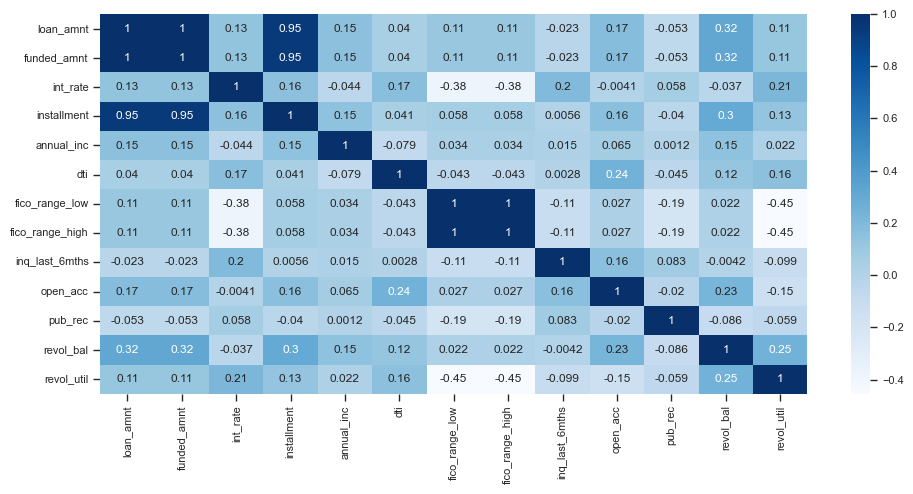

In [330]:
plt.figure(figsize = (10,5))

sns.set_context("paper", font_scale=0.9) 

sns.heatmap(x_train_norm[num_columns].corr(), 
        annot=True,
        cmap="Blues")

Loan amount and funded amount stringly correlates wuth annual incomea attribute (0.95).
The rest correlations are weak.

<b>Test data:</b>

In [331]:
round(x_test[num_columns].describe(),1).T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,238713.0,15099.7,9105.6,1000.0,8000.0,13000.0,20000.0,40000.0
funded_amnt,238713.0,15099.6,9105.6,1000.0,8000.0,13000.0,20000.0,40000.0
int_rate,238713.0,12.9,4.8,5.3,9.4,12.3,15.6,31.0
installment,238713.0,446.9,267.3,14.0,253.3,379.1,594.4,1719.8
annual_inc,238713.0,80567.6,73351.6,0.0,49000.0,68000.0,95828.5,9225000.0
dti,238713.0,18.8,10.3,0.0,12.2,18.1,24.8,999.0
fico_range_low,238713.0,696.4,31.8,660.0,670.0,690.0,710.0,845.0
fico_range_high,238713.0,700.4,31.8,664.0,674.0,694.0,714.0,850.0
inq_last_6mths,238713.0,0.5,0.8,0.0,0.0,0.0,1.0,6.0
open_acc,238713.0,11.9,5.8,1.0,8.0,11.0,15.0,93.0


In [332]:
x_test_norm_stg = x_test[cat_columns]

In [333]:
norm_data_test = preprocessing.normalize(x_test[num_columns], axis=0)
x_test_num = (pd.DataFrame(norm_data_test,columns=num_columns)).reset_index()
x_test_num = x_test_num.rename(columns={'index':'id'})

x_test_norm = pd.merge(x_test_norm_stg,x_test_num,how='left',on='id')
print(x_test_norm.shape)
x_test_norm.head(2)

(238713, 24)


,id,term,grade,sub_grade,emp_title_mod,emp_length,home_ownership,verification_status,purpose,addr_state,application_type,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util
0,0,36 months,B,B2,mortgage sale associate,2 years,RENT,Source Verified,debt_consolidation,CA,Individual,0.001219,0.001219,0.001360,0.001315,0.001221,0.001362,0.001938,0.001938,0.002041,0.001549,0.002994,0.000909,0.001331
1,1,36 months,C,C4,superintendant,10+ years,RENT,Verified,debt_consolidation,WA,Individual,0.000488,0.000488,0.002151,0.000568,0.001315,0.000906,0.001982,0.001982,0.000000,0.001084,0.000000,0.000650,0.001451


# Categorical values preparation

## Unique values overview

In [247]:
# Get list of categorical variables
s = (x_test.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['term', 'grade', 'sub_grade', 'emp_title_mod', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'application_type']


In [248]:
x_train.groupby('grade').addr_state.count()

grade
A    166276
B    284425
C    291554
D    129192
E     58953
F     18510
G      5940
Name: addr_state, dtype: int64

In [249]:
x_train.groupby('emp_length').addr_state.count() 


emp_length
1 year        67163
10+ years    344230
2 years       92417
3 years       81480
4 years       60719
5 years       61021
6 years       42944
7 years       38213
8 years       42020
9 years       38335
< 1 year      86308
Name: addr_state, dtype: int64

In [73]:
x_train.groupby('home_ownership').addr_state.count() 

home_ownership
ANY            344
MORTGAGE    471263
NONE             2
OWN         104609
RENT        378632
Name: addr_state, dtype: int64

In [74]:
x_train.groupby('application_type').addr_state.count()

application_type
Individual    920189
Joint App      34661
Name: addr_state, dtype: int64

In [250]:
print('Number of unique employment titles:', len(list(x_train.emp_title_mod.unique())))
job_titles = x_train.groupby('emp_title_mod').agg(Occur=('addr_state','count')).sort_values(by='Occur',ascending = False).reset_index()
job_titles['Share'] = round(job_titles.Occur/job_titles.Occur.sum()*100,1)
job_titles.head(15)

Number of unique employment titles: 130432


,emp_title_mod,Occur,Share
0,manager,143478,15.0
1,director,38660,4.0
2,sales,37273,3.9
3,engineer,29533,3.1
4,teacher,29481,3.1
5,supervisor,29281,3.1
6,analyst,26075,2.7
7,driver,25471,2.7
8,owner,23195,2.4
9,nurse,23054,2.4


As we can see there are 130 433 unique job titles. But some of the job possitions repeats among the loans applications and has some weight, e.g. 15% loans applicants says are managers, 4% says are directors.

There might be some different risks per different job position. Thus, this attribute could bring some information for the loans acceptance or rejection. We might try to create a dummy variales based on this information. E.g. top 10 most often job titles vs. the rest.

<b>Categorical variables distribution per adjustment approach</b>:

In [280]:
object_cols_ordinal = ['term', 'grade', 'sub_grade', 'emp_length']

object_cols_category = ['home_ownership', 'verification_status', 
                        'purpose', 'addr_state', 'application_type']

object_cols_dummies = ['emp_title_mod']

## Ordinal encoder

For categorical variables where order, sequence is important to present, has a natural ordering to them:

In [281]:
ordinal_encoder = OrdinalEncoder()

x_train_norm[object_cols_ordinal] = ordinal_encoder.fit_transform(x_train_norm[object_cols_ordinal])
x_test_norm[object_cols_ordinal] = ordinal_encoder.transform(x_test_norm[object_cols_ordinal])

x_test_norm[object_cols_ordinal].head(3)

,term,grade,sub_grade,emp_length
0,0.0,1.0,6.0,2.0
1,0.0,2.0,13.0,1.0
2,0.0,0.0,4.0,5.0


In [284]:
x_train_norm.shape

(954850, 24)

In [286]:
x_train_norm.head(2)

,id,term,grade,sub_grade,emp_title_mod,emp_length,home_ownership,verification_status,purpose,addr_state,application_type,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util
0,0,0.0,3.0,17.0,social worker,1.0,MORTGAGE,Verified,debt_consolidation,CA,Individual,0.000568,0.000568,0.001409,0.000705,0.000294,0.001157,0.000991,0.000991,0.004072,0.000928,0.001516,0.000243,0.000888
1,1,1.0,4.0,21.0,paralegal,10.0,MORTGAGE,Source Verified,debt_consolidation,AK,Individual,0.000761,0.000761,0.001377,0.000662,0.000231,0.001463,0.001057,0.001057,0.000000,0.000619,0.000000,0.000737,0.001644


In [282]:
x_train_norm

(954850, 24)

In [283]:
x_test_norm.shape

(238713, 24)

In [287]:
path_train = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/output_loans/train_test_ord_en/x_train_ord_en.csv'
path_test = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/output_loans/train_test_ord_en/x_test_ord_en.csv'
x_train_export = x_train_norm.drop(columns=['id'])
x_train_export.to_csv(path_train,index=False)
x_test_export = x_test_norm.drop(columns=['id'])
x_test_export.to_csv(path_test,index=False)

path_ytrain = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/output_loans/train_test_ord_en/y_train_ord_en.csv'
path_ytest = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/output_loans/train_test_ord_en/y_test_ord_en.csv'
y_train.to_csv(path_ytrain,index=False)
y_test.to_csv(path_ytest,index=False)

(238713, 24)

## One-Hot Encoding

For categorical values where order or sequence is absent

In [196]:
#from sklearn.compose import ColumnTransformer

In [288]:
OH_encoder = OneHotEncoder(handle_unknown='ignore',sparse_output=False)

labels = list(x_train_norm.home_ownership.unique())
ohe = ColumnTransformer(
    transformers=[("ohe", OH_encoder, object_cols_category),],
    remainder="passthrough",
)
ohe.set_output(transform="pandas")

OH_cols_train = pd.DataFrame(ohe.fit_transform(x_train_norm[object_cols_category]))
OH_cols_test = pd.DataFrame(ohe.transform(x_test_norm[object_cols_category]))

# # Remove categorical columns (will replace with one-hot encoding)
num_x_train = x_train_norm.drop(object_cols_category, axis=1)
num_x_test = x_test_norm.drop(object_cols_category, axis=1)

# # Add one-hot encoded columns to numerical features
x_train = pd.concat([num_x_train, OH_cols_train], axis=1)
x_test = pd.concat([num_x_test, OH_cols_test], axis=1)

In [289]:
x_train.head(3)
x_train.shape

(954850, 93)

In [291]:
print(x_test.shape)
x_test.head(3)

(238713, 93)


,id,term,grade,sub_grade,emp_title_mod,emp_length,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,ohe__home_ownership_ANY,ohe__home_ownership_MORTGAGE,ohe__home_ownership_NONE,ohe__home_ownership_OWN,ohe__home_ownership_RENT,ohe__verification_status_Not Verified,ohe__verification_status_Source Verified,ohe__verification_status_Verified,ohe__purpose_car,ohe__purpose_credit_card,ohe__purpose_debt_consolidation,ohe__purpose_educational,ohe__purpose_home_improvement,ohe__purpose_house,ohe__purpose_major_purchase,ohe__purpose_medical,ohe__purpose_moving,ohe__purpose_other,ohe__purpose_renewable_energy,ohe__purpose_small_business,ohe__purpose_vacation,ohe__purpose_wedding,ohe__addr_state_AK,ohe__addr_state_AL,ohe__addr_state_AR,ohe__addr_state_AZ,ohe__addr_state_CA,ohe__addr_state_CO,ohe__addr_state_CT,ohe__addr_state_DC,ohe__addr_state_DE,ohe__addr_state_FL,ohe__addr_state_GA,ohe__addr_state_HI,ohe__addr_state_ID,ohe__addr_state_IL,ohe__addr_state_IN,ohe__addr_state_KS,ohe__addr_state_KY,ohe__addr_state_LA,ohe__addr_state_MA,ohe__addr_state_MD,ohe__addr_state_ME,ohe__addr_state_MI,ohe__addr_state_MN,ohe__addr_state_MO,ohe__addr_state_MS,ohe__addr_state_MT,ohe__addr_state_NC,ohe__addr_state_ND,ohe__addr_state_NE,ohe__addr_state_NH,ohe__addr_state_NJ,ohe__addr_state_NM,ohe__addr_state_NV,ohe__addr_state_NY,ohe__addr_state_OH,ohe__addr_state_OK,ohe__addr_state_OR,ohe__addr_state_PA,ohe__addr_state_RI,ohe__addr_state_SC,ohe__addr_state_SD,ohe__addr_state_TN,ohe__addr_state_TX,ohe__addr_state_UT,ohe__addr_state_VA,ohe__addr_state_VT,ohe__addr_state_WA,ohe__addr_state_WI,ohe__addr_state_WV,ohe__addr_state_WY,ohe__application_type_Individual,ohe__application_type_Joint App
0,0,0.0,1.0,6.0,mortgage sale associate,2.0,0.001219,0.001219,0.001360,0.001315,0.001221,0.001362,0.001938,0.001938,0.002041,0.001549,0.002994,0.000909,0.001331,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,0.0,2.0,13.0,superintendant,1.0,0.000488,0.000488,0.002151,0.000568,0.001315,0.000906,0.001982,0.001982,0.000000,0.001084,0.000000,0.000650,0.001451,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,2,0.0,0.0,4.0,legal assistant,5.0,0.000813,0.000813,0.001183,0.000862,0.001277,0.001898,0.002041,0.002041,0.002041,0.002788,0.000000,0.000470,0.000889,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [292]:
path_train = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/output_loans/train_test_ohot_en/x_train_ohot_en.csv'
path_test = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/output_loans/train_test_ohot_en/x_test_ohot_en.csv'
x_train_export = x_train.drop(columns=['id'])
x_train_export.to_csv(path_train,index=False)
x_test_export = x_test.drop(columns=['id'])
x_test_export.to_csv(path_test,index=False)

path_ytrain = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/output_loans/train_test_ohot_en/y_train_ohot_en.csv'
path_ytest = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/output_loans/train_test_ohot_en/y_test_ohot_en.csv'
y_train.to_csv(path_ytrain,index=False)
y_test.to_csv(path_ytest,index=False)

## Dummy variables

<b>For training dataset:</b>

In [293]:
x_train['IsManager'] = np.where(x_train.emp_title_mod == 'manager', 1,0)
x_train['EmploymentTitleNaN'] = np.where(x_train.emp_title_mod == 'nan', 1,0)
x_train['IsDirector'] = np.where(x_train.emp_title_mod == 'director', 1,0)
x_train['IsSales'] = np.where(x_train.emp_title_mod == 'sales', 1,0)
x_train['IsEngineer'] = np.where(x_train.emp_title_mod == 'engineer', 1,0)
x_train['IsTeacher'] = np.where(x_train.emp_title_mod == 'teacher', 1,0)
x_train['IsSupervisor'] = np.where(x_train.emp_title_mod == 'supervisor', 1,0)
x_train['IsAnalyst'] = np.where(x_train.emp_title_mod == 'analyst', 1,0)
x_train['IsDriver'] = np.where(x_train.emp_title_mod == 'driver', 1,0)
x_train['IsOwner'] = np.where(x_train.emp_title_mod == 'owner', 1,0)
x_train['IsNurse'] = np.where(x_train.emp_title_mod == 'nurse', 1,0)

x_train = x_train.drop(columns = ['emp_title_mod'])
x_train.head(2)

,id,term,grade,sub_grade,emp_length,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,ohe__home_ownership_ANY,ohe__home_ownership_MORTGAGE,ohe__home_ownership_NONE,ohe__home_ownership_OWN,ohe__home_ownership_RENT,ohe__verification_status_Not Verified,ohe__verification_status_Source Verified,ohe__verification_status_Verified,ohe__purpose_car,ohe__purpose_credit_card,ohe__purpose_debt_consolidation,ohe__purpose_educational,ohe__purpose_home_improvement,ohe__purpose_house,ohe__purpose_major_purchase,ohe__purpose_medical,ohe__purpose_moving,ohe__purpose_other,ohe__purpose_renewable_energy,ohe__purpose_small_business,ohe__purpose_vacation,ohe__purpose_wedding,ohe__addr_state_AK,ohe__addr_state_AL,ohe__addr_state_AR,ohe__addr_state_AZ,ohe__addr_state_CA,ohe__addr_state_CO,ohe__addr_state_CT,ohe__addr_state_DC,ohe__addr_state_DE,ohe__addr_state_FL,ohe__addr_state_GA,ohe__addr_state_HI,ohe__addr_state_ID,ohe__addr_state_IL,ohe__addr_state_IN,ohe__addr_state_KS,ohe__addr_state_KY,ohe__addr_state_LA,ohe__addr_state_MA,ohe__addr_state_MD,ohe__addr_state_ME,ohe__addr_state_MI,ohe__addr_state_MN,ohe__addr_state_MO,ohe__addr_state_MS,ohe__addr_state_MT,ohe__addr_state_NC,ohe__addr_state_ND,ohe__addr_state_NE,ohe__addr_state_NH,ohe__addr_state_NJ,ohe__addr_state_NM,ohe__addr_state_NV,ohe__addr_state_NY,ohe__addr_state_OH,ohe__addr_state_OK,ohe__addr_state_OR,ohe__addr_state_PA,ohe__addr_state_RI,ohe__addr_state_SC,ohe__addr_state_SD,ohe__addr_state_TN,ohe__addr_state_TX,ohe__addr_state_UT,ohe__addr_state_VA,ohe__addr_state_VT,ohe__addr_state_WA,ohe__addr_state_WI,ohe__addr_state_WV,ohe__addr_state_WY,ohe__application_type_Individual,ohe__application_type_Joint App,IsManager,EmploymentTitleNaN,IsDirector,IsSales,IsEngineer,IsTeacher,IsSupervisor,IsAnalyst,IsDriver,IsOwner,IsNurse
0,0,0.0,3.0,17.0,1.0,0.000568,0.000568,0.001409,0.000705,0.000294,0.001157,0.000991,0.000991,0.004072,0.000928,0.001516,0.000243,0.000888,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0
1,1,1.0,4.0,21.0,10.0,0.000761,0.000761,0.001377,0.000662,0.000231,0.001463,0.001057,0.001057,0.000000,0.000619,0.000000,0.000737,0.001644,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0


<b>For test dataset:</b>

In [294]:
x_test['IsManager'] = np.where(x_test.emp_title_mod == 'manager', 1,0)
x_test['EmploymentTitleNaN'] = np.where(x_test.emp_title_mod == 'nan', 1,0)
x_test['IsDirector'] = np.where(x_test.emp_title_mod == 'director', 1,0)
x_test['IsSales'] = np.where(x_test.emp_title_mod == 'sales', 1,0)
x_test['IsEngineer'] = np.where(x_test.emp_title_mod == 'engineer', 1,0)
x_test['IsTeacher'] = np.where(x_test.emp_title_mod == 'teacher', 1,0)
x_test['IsSupervisor'] = np.where(x_test.emp_title_mod == 'supervisor', 1,0)
x_test['IsAnalyst'] = np.where(x_test.emp_title_mod == 'analyst', 1,0)
x_test['IsDriver'] = np.where(x_test.emp_title_mod == 'driver', 1,0)
x_test['IsOwner'] = np.where(x_test.emp_title_mod == 'owner', 1,0)
x_test['IsNurse'] = np.where(x_test.emp_title_mod == 'nurse', 1,0)

x_test = x_test.drop(columns = ['emp_title_mod'])
x_test.head(2)

,id,term,grade,sub_grade,emp_length,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,ohe__home_ownership_ANY,ohe__home_ownership_MORTGAGE,ohe__home_ownership_NONE,ohe__home_ownership_OWN,ohe__home_ownership_RENT,ohe__verification_status_Not Verified,ohe__verification_status_Source Verified,ohe__verification_status_Verified,ohe__purpose_car,ohe__purpose_credit_card,ohe__purpose_debt_consolidation,ohe__purpose_educational,ohe__purpose_home_improvement,ohe__purpose_house,ohe__purpose_major_purchase,ohe__purpose_medical,ohe__purpose_moving,ohe__purpose_other,ohe__purpose_renewable_energy,ohe__purpose_small_business,ohe__purpose_vacation,ohe__purpose_wedding,ohe__addr_state_AK,ohe__addr_state_AL,ohe__addr_state_AR,ohe__addr_state_AZ,ohe__addr_state_CA,ohe__addr_state_CO,ohe__addr_state_CT,ohe__addr_state_DC,ohe__addr_state_DE,ohe__addr_state_FL,ohe__addr_state_GA,ohe__addr_state_HI,ohe__addr_state_ID,ohe__addr_state_IL,ohe__addr_state_IN,ohe__addr_state_KS,ohe__addr_state_KY,ohe__addr_state_LA,ohe__addr_state_MA,ohe__addr_state_MD,ohe__addr_state_ME,ohe__addr_state_MI,ohe__addr_state_MN,ohe__addr_state_MO,ohe__addr_state_MS,ohe__addr_state_MT,ohe__addr_state_NC,ohe__addr_state_ND,ohe__addr_state_NE,ohe__addr_state_NH,ohe__addr_state_NJ,ohe__addr_state_NM,ohe__addr_state_NV,ohe__addr_state_NY,ohe__addr_state_OH,ohe__addr_state_OK,ohe__addr_state_OR,ohe__addr_state_PA,ohe__addr_state_RI,ohe__addr_state_SC,ohe__addr_state_SD,ohe__addr_state_TN,ohe__addr_state_TX,ohe__addr_state_UT,ohe__addr_state_VA,ohe__addr_state_VT,ohe__addr_state_WA,ohe__addr_state_WI,ohe__addr_state_WV,ohe__addr_state_WY,ohe__application_type_Individual,ohe__application_type_Joint App,IsManager,EmploymentTitleNaN,IsDirector,IsSales,IsEngineer,IsTeacher,IsSupervisor,IsAnalyst,IsDriver,IsOwner,IsNurse
0,0,0.0,1.0,6.0,2.0,0.001219,0.001219,0.001360,0.001315,0.001221,0.001362,0.001938,0.001938,0.002041,0.001549,0.002994,0.000909,0.001331,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0
1,1,0.0,2.0,13.0,1.0,0.000488,0.000488,0.002151,0.000568,0.001315,0.000906,0.001982,0.001982,0.000000,0.001084,0.000000,0.000650,0.001451,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0


In [295]:
path_train = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/output_loans/train_test_dum_en/x_train_dum_en.csv'
path_test = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/output_loans/train_test_dum_en/x_test_dum_en.csv'
x_train_export = x_train.drop(columns=['id'])
x_train_export.to_csv(path_train,index=False)
x_test_export = x_test.drop(columns=['id'])
x_test_export.to_csv(path_test,index=False)

path_ytrain = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/output_loans/train_test_dum_en/y_train_dum_en.csv'
path_ytest = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/output_loans/train_test_dum_en/y_test_dum_en.csv'
y_train.to_csv(path_ytrain,index=False)
y_test.to_csv(path_ytest,index=False)

# Principal Component Analysis (PCA)

<b>Principal component analysis (PCA</b>) is a technique that transforms high-dimensions data into lower-dimensions while retaining as much information as possible.

PCA use cases in feature engineering:
- <b>Dimensionality reduction</b>: When your features are highly redundant (multicollinear, specifically), PCA will partition out the redundancy into one or more near-zero variance components, which you can then drop since they will contain little or no information.
- <b>Anomaly detection</b>: Unusual variation, not apparent from the original features, will often show up in the low-variance components. These components could be highly informative in an anomaly or outlier detection task.
- <b>Noise reduction</b>: A collection of sensor readings will often share some common background noise. PCA can sometimes collect the (informative) signal into a smaller number of features while leaving the noise alone, thus boosting the signal-to-noise ratio.
- <b>Decorrelation</b>: Some ML algorithms struggle with highly-correlated features. PCA transforms correlated features into uncorrelated components, which could be easier for your algorithm to work with.

We will load the data which is prepared for the training:
- missing numeric values imputation
- numeric values normalisation
- categorical values ordinal encoding applied, which presents the order importance 

In [297]:
path_ = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/output_loans/train_test_ord_en/x_train_ord_en.csv'
x_train = pd.read_csv(path_)
print(list(x_train.columns))
x_train.head(4)

['term', 'grade', 'sub_grade', 'emp_title_mod', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'application_type', 'loan_amnt', 'funded_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util']


,term,grade,sub_grade,emp_title_mod,emp_length,home_ownership,verification_status,purpose,addr_state,application_type,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util
0,0.0,3.0,17.0,social worker,1.0,MORTGAGE,Verified,debt_consolidation,CA,Individual,0.000568,0.000568,0.001409,0.000705,0.000294,0.001157,0.000991,0.000991,0.004072,0.000928,0.001516,0.000243,0.000888
1,1.0,4.0,21.0,paralegal,10.0,MORTGAGE,Source Verified,debt_consolidation,AK,Individual,0.000761,0.000761,0.001377,0.000662,0.000231,0.001463,0.001057,0.001057,0.000000,0.000619,0.000000,0.000737,0.001644
2,0.0,0.0,0.0,owner,1.0,RENT,Not Verified,debt_consolidation,NY,Individual,0.000580,0.000580,0.000395,0.000591,0.000374,0.000354,0.001101,0.001100,0.000000,0.000696,0.000000,0.000623,0.000564
3,1.0,1.0,5.0,engineer,3.0,MORTGAGE,Not Verified,home_improvement,NC,Individual,0.000927,0.000927,0.000667,0.000651,0.000428,0.000360,0.001049,0.001049,0.000000,0.000309,0.000000,0.000000,0.000000


In [310]:
cols = ['term', 'grade', 'sub_grade', 'emp_length', 
 'loan_amnt', 'funded_amnt', 'int_rate', 
 'installment', 'annual_inc', 'dti', 'fico_range_low', 
 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util']

x_train_pca = x_train[cols]
print(x_train_pca.shape) 

X_scaled = StandardScaler().fit_transform(x_train_pca)

x_train_scaled = pd.DataFrame(X_scaled, columns=cols)
x_train_scaled.head(2)

(954850, 17)


,term,grade,sub_grade,emp_length,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util
0,-0.640069,1.044944,1.050352,-0.798553,-0.584058,-0.584056,1.258401,-0.330093,-0.210571,0.528075,-0.672733,-0.672723,4.092764,0.015475,1.214634,-0.420488,-0.079354
1,1.562330,1.846079,1.690039,2.018508,-0.219203,-0.219201,1.167217,-0.412013,-0.280822,1.139797,0.736599,0.736577,-0.647435,-0.680220,-0.359410,0.172364,1.632345


In [311]:
path_ = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/output_loans/train_test_ord_en/y_train_ord_en.csv'
y_train = pd.read_csv(path_)
print(list(y_train.columns))
y_train.head(4)

['LoanAcceptRejectFlag']


,LoanAcceptRejectFlag
0,0
1,1
2,0
3,0


In [312]:
# Create principal components
pca = PCA()
X_pca = pca.fit_transform(x_train_scaled)

# # Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17
0,1.746211,-2.182792,-0.977655,1.702889,2.521984,0.394336,-0.219603,-1.484301,0.306811,-1.742789,1.276972,-0.129652,-0.126363,-0.065494,0.138237,-2.453060e-06,0.000004
1,2.180956,-0.610785,-1.607810,-0.497182,-2.555863,-1.121017,1.260309,0.988676,-0.379165,-0.997980,0.352980,-0.859469,0.427225,0.115287,-0.245973,5.350979e-06,-0.000022
2,-3.812952,0.928307,-0.455266,-0.654575,-0.159419,0.894862,-0.288876,-0.163991,-0.292271,-0.305325,-0.363338,-0.158966,0.172709,-0.118250,-0.007428,6.157331e-07,-0.000032
3,-1.712562,0.633759,-1.363162,-1.838027,0.262301,0.348755,-0.192722,0.379432,-0.926111,0.956338,0.579105,1.557355,0.183944,-0.161984,-0.037739,2.238362e-06,-0.000007
4,-0.972854,-2.105368,0.871884,-0.967704,-0.048363,0.201568,-0.020232,-0.259616,0.271814,0.657471,-0.138667,1.063462,-0.265626,0.081669,0.012993,-6.531611e-06,0.000018


We'll wrap the loadings up in a dataframe.

In [313]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=x_train_scaled.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17
term,0.244522,0.122595,-0.260810,-0.102422,-0.140304,0.112285,-0.006095,0.344932,-0.584938,0.249753,0.456939,0.099863,-0.041557,-0.147010,-0.220737,8.466548e-06,2.705382e-06
grade,0.428327,-0.149781,-0.259654,-0.031136,-0.036062,0.053371,0.058243,-0.005791,0.075696,-0.068474,-0.187130,-0.046537,0.768630,-0.265097,0.097303,8.042992e-06,-3.381545e-06
sub_grade,0.435085,-0.153313,-0.252474,-0.030582,-0.037118,0.050086,0.055804,-0.008044,0.074238,-0.063994,-0.174624,-0.039768,-0.130428,0.724814,-0.362497,-3.506221e-06,-3.396682e-06
emp_length,-0.003846,-0.017701,-0.041461,-0.054934,-0.079370,-0.824500,0.541911,0.064145,-0.102878,-0.008562,-0.017713,-0.008917,-0.000549,-0.001391,-0.000040,1.342351e-06,3.416673e-07
loan_amnt,0.236048,0.467427,0.074581,-0.117480,0.079480,-0.088327,-0.095581,-0.046558,0.031517,0.057764,0.084726,0.039623,0.047701,0.204322,0.352035,7.070908e-01,-3.211559e-06
funded_amnt,0.236048,0.467427,0.074580,-0.117479,0.079482,-0.088329,-0.095580,-0.046558,0.031518,0.057764,0.084722,0.039624,0.047710,0.204291,0.351987,-7.071228e-01,1.090396e-06
int_rate,0.427683,-0.147821,-0.264165,-0.032986,-0.036511,0.052870,0.058415,-0.011081,0.092036,-0.073663,-0.203932,-0.041560,-0.615426,-0.390559,0.358055,-6.228610e-06,1.940259e-06
installment,0.231209,0.433339,0.128740,-0.095709,0.129940,-0.126940,-0.095057,-0.169708,0.252300,-0.030919,-0.098570,-0.003328,-0.084326,-0.382714,-0.658992,3.045533e-05,3.100472e-06
annual_inc,0.016420,0.130440,0.129967,0.013326,0.238701,0.400145,0.685659,0.373480,0.341276,0.090008,0.117760,0.022209,0.000035,0.001072,-0.002023,2.519312e-07,5.026730e-08
dti,0.112394,0.003632,-0.031981,0.518271,-0.401305,-0.163084,-0.186035,0.252185,0.452145,-0.152906,0.364105,0.267329,0.001692,-0.004559,0.001379,-1.154991e-06,2.992198e-06


Recall that the signs and magnitudes of a component's loadings tell us what kind of variation it's captured.

array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

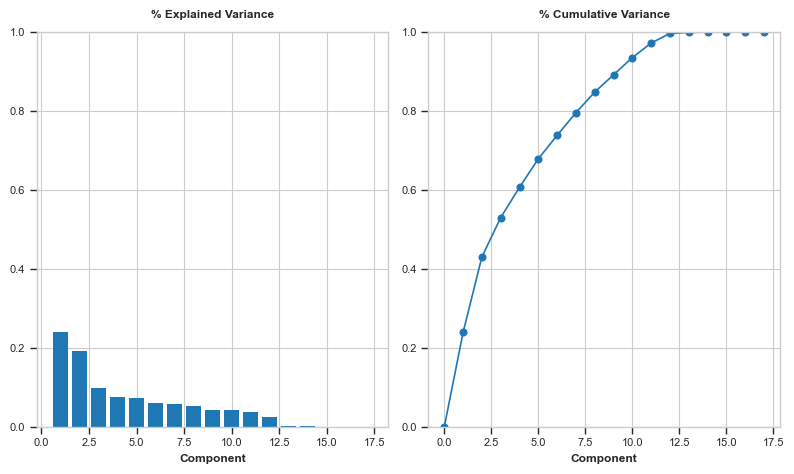

In [314]:
# Look at explained variance
plot_variance(pca)

The chart informs us that using 8 principal components instead of 17 is fine because they can capture 90%+ of the variance.

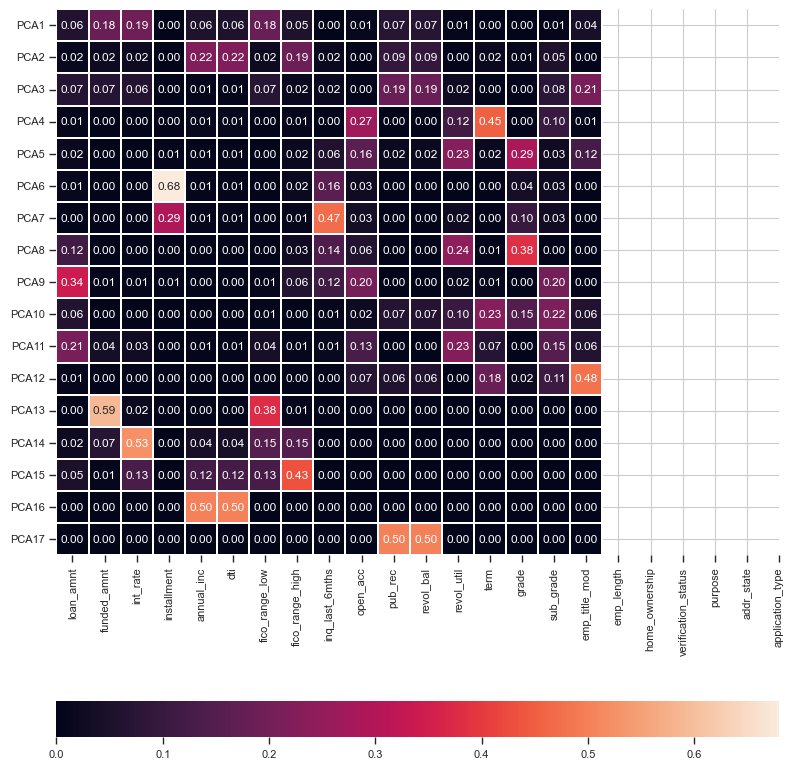

In [315]:
plt.figure(figsize=(8,10))

# Feature Weight
_ = sns.heatmap(pca.components_**2,
                 yticklabels=["PCA"+str(x) for x in range(1,pca.n_components_+1)],
                 xticklabels=list(features),
                 annot=True,
                 fmt='.2f',
                 square=True,
                 linewidths=0.05,
                 cbar_kws={"orientation": "horizontal"})

We can see that PCA1 is made from 19% of interest rate, 18% of fundend amount, and 18% of FICO range low. 

PCA6 is most made from installment (68%).

PCA4 is made from term (45%) ad open acc (27%)

Let's also look at the MI scores of the components.

In [317]:
mi_scores = make_mi_scores(X_pca, y_train, discrete_features=False)
mi_scores

PC1     0.024488
PC13    0.006767
PC14    0.005926
PC15    0.005497
PC17    0.004884
PC16    0.004472
PC2     0.002972
PC3     0.002749
PC8     0.001890
PC9     0.001667
PC11    0.001292
PC5     0.000912
PC4     0.000688
PC7     0.000515
PC10    0.000446
PC6     0.000211
PC12    0.000187
Name: MI Scores, dtype: float64